<font size="4">**Importy**</font>

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math 
from scipy import misc, signal
import numpy as np
import matplotlib.pyplot as plt

<font size="4">**Inicjalizacja zmiennych**</font>

In [3]:
dx=1.0 # krok alfa w stopniach
dAlfa = dx*math.pi/180 # krok alfa w radianach
rozpietosc = math.pi # rozpietosc emiterów/detektorów
liczbaDetektorow = 180 # liczba detektorów i emiterów
filtr = True # czy użyć filtra

<font size="4">**Algorytm Bresenhama**</font>

In [4]:
def bresenham(x0,y0,x1,y1):
    x = x0
    y = y0
    punkty = []
    if(x0 < x1):
        xi = 1
        dx = x1 - x0
    else:
        xi = -1
        dx = x0 - x1
    if(y0 < y1):
        yi = 1
        dy = y1 - y0
    else:
        yi = -1
        dy = y0 - y1
    punkty.append((x,y))
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while (x != x1):
            if (d >= 0):
                x = x + xi
                y = y + yi
                d = d + ai
            else:
                d = d + bi
                x = x + xi
            punkty.append((x,y))
    else:
        ai = ( dx - dy ) * 2;
        bi = dx * 2;
        d = bi - dy;
        while y != y1:
            if d >= 1:
                x = x + xi
                y = y + yi
                d = d + ai
            else:
                d =d + bi
                y =y + yi
            punkty.append((x,y))
    return punkty

<font size="4">**Transformacja radona (obraz na sinogram)**</font>

In [5]:
def radon(zdjecie, dAlfa, rozpietosc, liczbaDetektorow, dx):
    alfa = math.pi/2
    n = math.ceil(180/dx)+1
    detektory = [[0,0] for i in range(liczbaDetektorow)]
    emitery = [[0,0] for i in range(liczbaDetektorow)]
    wysokosc = len(zdjecie)
    szerokosc = len(zdjecie[0])
    r = math.floor(math.sqrt(wysokosc**2 + szerokosc**2)/2) 

    obraz = [[0 for i in range(r*2)] for j in range(r*2)]
    w,s = zdjecie.shape
    yoff = round((r*2-w)/2)
    xoff = round((r*2-s)/2)
    obraz = np.array(obraz.copy())
    obraz[yoff:yoff+w,xoff:xoff+s] = zdjecie
    
    sinogram = []
    for j in range(n):
        linia = [0 for i in range(liczbaDetektorow)]
        for i in range(liczbaDetektorow):
            x = r*math.cos(alfa + math.pi - (1/2)*rozpietosc + i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
            y = r*math.sin(alfa + math.pi - (1/2)*rozpietosc + i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
            detektory[i] = [round(x),round(y)]
            xe = r*math.cos(alfa + (1/2)*rozpietosc - i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
            ye = r*math.sin(alfa + (1/2)*rozpietosc - i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
            emitery[i] = [round(xe),round(ye)]
            punkty_linii = bresenham(emitery[i][0],emitery[i][1],detektory[i][0],detektory[i][1])
            k = 1
            for xp,yp in punkty_linii:
                if(xp+r>xoff and yp+r>yoff and xp+r<xoff+s and yp+r<yoff+w):
                    linia[i] += obraz[xp+r-1][yp+r-1]
                    k += 1
            
            if(k>1):
                k -= 1
            linia[i] /= k

        sinogram.append(linia)

    sinogram = np.rot90(sinogram,1, axes=(0,1))
    return sinogram

<font size="4">**Projekcja wsteczna**</font>

In [6]:
def iradon(sinogram, dx):
    x = np.arange(sinogram.shape[0])-sinogram.shape[0]/2 #create coordinate system centered at (x,y = 0,0)
    y = x.copy()
    X, Y = np.meshgrid(x, y)
    projekcje = []
    liczbaN = sinogram.shape[0]
    rekonstrukcja = np.array([[0 for i in range(liczbaN)] for j in range(liczbaN)])
    katy = np.arange(0.0,180,dx)*(-1)*math.pi/180

    for j in range(len(katy)):
        projekcja = np.array([[0 for i in range(liczbaN)] for j in range(liczbaN)])
        rot = X*math.sin(katy[j])-Y*math.cos(katy[j])
        punkty = np.round(rot + liczbaN/2)
        punkty = punkty.astype('int')
        p1, p2 = np.where((punkty>=0) & (punkty<liczbaN))
        linia = sinogram[:,j-1]
        projekcja[p1,p2] = linia[punkty[p1,p2]] 
        rekonstrukcja += projekcja
        projekcje.append(projekcja)
        
    rekonstrukcja = rekonstrukcja//len(katy)    
    return rekonstrukcja, projekcje

<font size="4">**Filtrowanie**</font>

In [7]:
def filtruj(sinogram):
    h = np.array([[-1, -1, -1],
                  [-1, 9, -1],
                  [-1, -1, -1],],
                  dtype='float')
    zfiltrowanyObraz = signal.convolve2d(sinogram, h)
    zfiltrowanyObraz = zfiltrowanyObraz[2:-2,2:-2]
    return zfiltrowanyObraz

<font size="4">**Skalowanie do wielkości oryginalnego obrazu (do liczenia błędu średniokwadratowego)**</font>

In [8]:
from PIL import Image
def skalujObraz(obraz, w, s):
    img = Image.fromarray(obraz)
    img = img.resize((w,s))
    resized = np.array(img)
    return resized

<font size="4">**Suwaki, dobieranie wartości zmiennych**</font>

In [10]:
def podajKrokAlfa(krok):
    global dAlfa 
    global dx
    dAlfa = krok*math.pi/180
    dx= dAlfa*180/math.pi
def podajIloscDetektorow(ile):
    global liczbaDetektorow 
    liczbaDetektorow = ile
def podajRozpietosc(stopnie):
    global rozpietosc 
    rozpietosc = stopnie*math.pi/180
def czyFiltrowac(f):
    global filtr
    filtr = f
interact(podajKrokAlfa,krok=widgets.FloatSlider(description='Krok alfa:',min=0.25,max=5.0,step=0.25,value=dx))
interact(podajIloscDetektorow,ile=widgets.IntSlider(description='Liczba detektorów:',min=10,max=500,step=10,value=liczbaDetektorow))
interact(podajRozpietosc,stopnie=widgets.IntSlider(description='Rozpiętość:',min=0,max=360,step=10,value=rozpietosc/math.pi/2*180))
interact(czyFiltrowac, f=widgets.Checkbox(value=True, description='Filtrowanie', indent=filtr))


interactive(children=(FloatSlider(value=1.0, description='Krok alfa:', max=5.0, min=0.25, step=0.25), Output()…

interactive(children=(IntSlider(value=180, description='Liczba detektorów:', max=500, min=10, step=10), Output…

interactive(children=(IntSlider(value=90, description='Rozpiętość:', max=360, step=10), Output()), _dom_classe…

interactive(children=(Checkbox(value=True, description='Filtrowanie'), Output()), _dom_classes=('widget-intera…

<function __main__.czyFiltrowac(f)>

C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


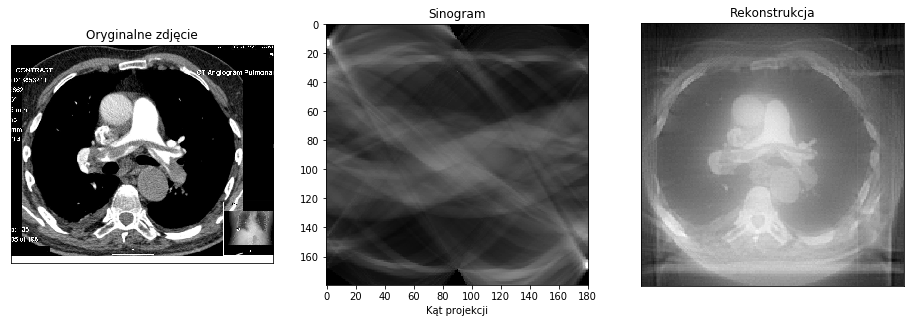

In [11]:
#def tomografia(zdjecie, dAlfa, rozpietosc, liczbaDetektorow, dx, fil):
zdjecie = misc.imread('SADDLE_PE.JPG', flatten=True).astype('float64')
sinogram = radon(zdjecie, dAlfa, rozpietosc, liczbaDetektorow, dx)
rekonstrukcja, kolejneProjekcje = iradon(sinogram, dx)
sinogram2 = sinogram
if(filtr):
    sinogram2 = filtruj(sinogram)
rekonstrukcja, kolejneProjekcje = iradon(sinogram2, dx)


plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.2)
sub1 = plt.subplot(131)
sub1.set_title("Oryginalne zdjęcie")
sub1.set_xticks([],[])
sub1.set_yticks([],[])
sub1.imshow(zdjecie, cmap='gray')

xlabels=[i*20 for i in range(10)]
sub2 = plt.subplot(132)
sub2.set_xticks(np.arange(0, 181/dx, 20/dx))
sub2.set_xticklabels(xlabels)
sub2.set_xlabel("Kąt projekcji")
sub2.set_title("Sinogram")
sub2.imshow(sinogram, cmap='gray')

sub3 = plt.subplot(133)
sub3.set_title("Rekonstrukcja")
sub3.set_xticks([],[])
sub3.set_yticks([],[])
sub3.imshow(rekonstrukcja, cmap='gray')

<font size="5">**Iteracyjna prezentacja**</font>
<br>Pokaz rekonstrukcji w danej iteracji przy pomocy suwaka</br>

interactive(children=(IntSlider(value=181, description='Liczba iteracji:', max=181, min=1), Output()), _dom_cl…

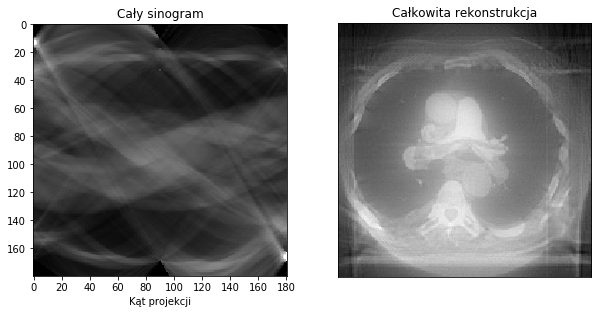

In [12]:
def liczbaIteracji(iteracji):
    global plt
    liczbaIteracji = iteracji
    plt.figure(figsize=(10,10))
    xlabels=[i*20 for i in range(10)]
    global sub3
    sub3 = plt.subplot(121)
    sub3.set_xticks(np.arange(0, 181/dx, 20/dx))
    sub3.set_xticklabels(xlabels)
    sub3.set_xlabel("Kąt projekcji")
    sub3.set_title("Sinogram po " + str(liczbaIteracji) + " iteracjach")
    sinogram2 = np.array([[0 for i in range(len(sinogram[0]))] for j in range(len(sinogram))])
    sinogram2[:,:liczbaIteracji] = sinogram[:,:liczbaIteracji]
    sub3.imshow(sinogram2, cmap='gray')
    global kolejneProjekcje
    rekonstrukcja = sum(kolejneProjekcje[:liczbaIteracji+1])
    
    global sub4
    sub4 = plt.subplot(122)
    sub4.set_title("Rekonstrukcja (" + str(liczbaIteracji) + " iteracji)")
    sub4.set_xticks([],[])
    sub4.set_yticks([],[])
    sub4.imshow(rekonstrukcja, cmap='gray')
    
interact(liczbaIteracji,iteracji=widgets.IntSlider(description='Liczba iteracji:',min=1,max=math.ceil(180/dx)+1,step=1,value=math.ceil(180/dx)+1))
plt.figure(figsize=(10,10))
xlabels=[i*20 for i in range(10)]
sub1 = plt.subplot(121)
sub1.set_xticks(np.arange(0, 181/dx, 20/dx))
sub1.set_xticklabels(xlabels)
sub1.set_xlabel("Kąt projekcji")
sub1.set_title("Cały sinogram")
sub1.imshow(sinogram, cmap='gray')


sub2 = plt.subplot(122)
sub2.set_title("Całkowita rekonstrukcja")
sub2.set_xticks([],[])
sub2.set_yticks([],[])
sub2.imshow(sum(kolejneProjekcje), cmap='gray')


<font size="5">**Format Dicom**</font>

In [13]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

# strona dla której działa https://www.dicomlibrary.com

def zapiszDicom(imie, data, komentarz):
    obrazDicom = (rekonstrukcja).astype(np.uint16)

    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    zbior = Dataset()
    zbior.file_meta = meta

    zbior.is_little_endian = True
    zbior.is_implicit_VR = False

    zbior.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    zbior.PatientName = imie
    zbior.StudyDate = data
    zbior.StudyDescription = komentarz
    
    zbior.Modality = "MR"
    zbior.SeriesInstanceUID = pydicom.uid.generate_uid()
    zbior.StudyInstanceUID = pydicom.uid.generate_uid()
    zbior.FrameOfReferenceUID = pydicom.uid.generate_uid()

    zbior.BitsAllocated = 16
    zbior.BitsStored = 16
    zbior.HighBit = 15
    zbior.SamplesPerPixel = 1
    zbior.ImagesInAquisition = "1" 
    zbior.Rows = len(obrazDicom)
    zbior.Columns = len(obrazDicom[0])
    zbiorInstanceNumber = 1

    zbior.ImagePositionPatient = r"0\0\1"
    zbior.ImageOrientationPatient = r"1\0\0\0\-1\0"
    zbior.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    zbior.RescaleIntercept = "0"
    zbior.RescaleSlope = "1"
    zbior.PixelSpacing = r"1\1"
    zbior.PhotometricInterpretation = "MONOCHROME2"
    zbior.PixelRepresentation = 1

    pydicom.dataset.validate_file_meta(zbior.file_meta, enforce_standard = True)
    zbior.PixelData = obrazDicom.tobytes()
    zbior.save_as("dicom.dcm")
    
zapiszDicom("Jan Kowalski","20/12/2019","Tomograf komputerowy pacjenta")

Informacje
Imie:  Jan Kowalski
Data:  20/12/2019
Komentarz:  Tomograf komputerowy pacjenta


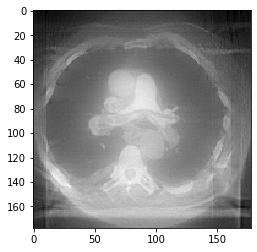

In [14]:
def otworzDicom(nazwaPliku):
    infoPacjenta = pydicom.dcmread(nazwaPliku, force=True)
    imiePacjenta = infoPacjenta.PatientName
    data = infoPacjenta.StudyDate
    komentarz = infoPacjenta.StudyDescription
    print("Informacje")
    print("Imie: ", imiePacjenta)
    print("Data: ", data)
    print("Komentarz: ", komentarz)
    plt.imshow(infoPacjenta.pixel_array,cmap="gray")
otworzDicom("dicom.dcm")

<font size="5">**Obliczanie błędu średniokwadratowego**</font>

In [163]:
zdjecie2 = misc.imread('SADDLE_PE.JPG', flatten=True).astype('float64')
rekonstrukcja2 = tomografia(zdjecie2, dAlfa, rozpietosc, liczbaDetektorow, dx)
rekonstrukcja2 = skalujObraz(rekonstrukcja, zdjecie.shape[1], zdjecie2.shape[0])
błąd = []

MSE = 0.0
for i in range(zdjecie.shape[0]):
    for j in range(zdjecie.shape[1]):
        MSE += (rekonstrukcja2[i][j] - zdjecie[i][j])**2
        
MSE = MSE/(zdjecie.shape[0]*zdjecie.shape[1])
MSE

C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


6776.54222118149

C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


85.12401255404876
82.33254098961103
88.38213281220648
91.69561886747844
93.6259645682364
94.50797963809902


C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


91.89289218135599
91.69561886747844
91.68838983270221
91.68898603461516
91.69388592389294
91.69033535359222
91.69299801932004
91.7007449731822


C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


91.73644723429035
91.69561886747844
91.69326173317843
91.6923947614108
91.69595220372781
91.68997204211635
91.68930874784917
91.69270834109804


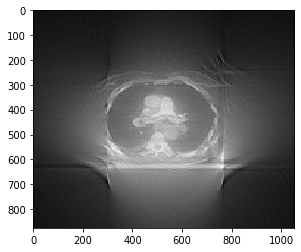

In [220]:
#EKSPERYMENT #ZMIANY parametrów
'''
rozpietosci = [45*(x+1)*math.pi/180 for x in range(6)]
liczbyDetektorow = [90,180,270,360,450,540,630,720]
dAlfaTab = [(180/((x+1)*90))*math.pi/180 for x in range(8)]
dxTab = [180/((x+1)*90) for x in range(8)]
bladR = []
rekonstrukcjeR = []
for rozpietosc in rozpietosci:
    dx = 1.0
    dAlfa = dx*math.pi/180
    liczbaDetektorow = 180
    zdjecie = misc.imread('SADDLE_PE.JPG', flatten=True).astype('float64')
    rekonstrukcja = tomografia(zdjecie, dAlfa, rozpietosc, liczbaDetektorow, dx)
    rekonstrukcja = skalujObraz(rekonstrukcja, zdjecie.shape[1], zdjecie.shape[0])
    rekonstrukcjeR.append(rekonstrukcja)
    MSE = 0.0
    for i in range(zdjecie.shape[0]):
        for j in range(zdjecie.shape[1]):
            MSE += (rekonstrukcja[i][j] - zdjecie[i][j])**2
    MSE = MSE/(zdjecie.shape[0]*zdjecie.shape[1])
    RMSE = MSE**0.5
    
    print(RMSE)
    plt.imshow(rekonstrukcja, cmap="gray")
    bladR.append(RMSE)
bladL = []
rekonstrukcjeL = []
for liczbaDetektorow in liczbyDetektorow:
    dx = 1.0
    dAlfa = dx*math.pi/180
    rozpietosc = math.pi
    zdjecie2 = misc.imread('SADDLE_PE.JPG', flatten=True).astype('float64')
    rekonstrukcja2 = tomografia(zdjecie2, dAlfa, rozpietosc, liczbaDetektorow, dx)
    rekonstrukcja2 = skalujObraz(rekonstrukcja2, zdjecie2.shape[1], zdjecie2.shape[0])
    rekonstrukcjeL.append(rekonstrukcja2)
    MSE = 0.0
    for i in range(zdjecie2.shape[0]):
        for j in range(zdjecie2.shape[1]):
            MSE += (rekonstrukcja2[i][j] - zdjecie2[i][j])**2
    MSE = MSE/(zdjecie2.shape[0]*zdjecie2.shape[1])
    RMSE = MSE**0.5
    print(RMSE)
    plt.imshow(rekonstrukcja2, cmap="gray")
    bladL.append(RMSE)
bladA = []
rekonstrukcjeA = []
for dAlfa, dx in zip(dAlfaTab,dxTab):
    liczbaDetektorow = 180
    rozpietosc = math.pi
    zdjecie2 = misc.imread('SADDLE_PE.JPG', flatten=True).astype('float64')
    rekonstrukcja2 = tomografia(zdjecie2, dAlfa, rozpietosc, liczbaDetektorow, dx)
    rekonstrukcja2 = skalujObraz(rekonstrukcja2, zdjecie2.shape[1], zdjecie2.shape[0])
    rekonstrukcjeA.append(rekonstrukcja2)
    MSE = 0.0
    for i in range(zdjecie2.shape[0]):
        for j in range(zdjecie2.shape[1]):
            MSE += (rekonstrukcja2[i][j] - zdjecie2[i][j])**2
    MSE = MSE/(zdjecie2.shape[0]*zdjecie2.shape[1])
    RMSE = MSE**0.5
    print(RMSE)
    plt.imshow(rekonstrukcja2, cmap="gray")
    bladA.append(RMSE)
    '''

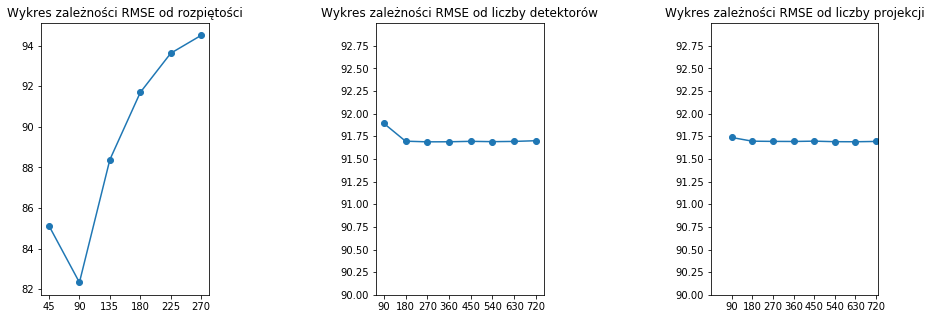

In [282]:
'''
plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=1.0)
subR = plt.subplot(131)
rozp = np.array(rozpietosci)*180/math.pi
subR.set_xticks(rozp)
subR.set_title("Wykres zależności RMSE od rozpiętości")
subR.plot(rozp, bladR, marker='o')
subL = plt.subplot(132)
subL.set_yticks(np.arange(90.0,93.0,0.25))
subL.set_ylim(90.0,93.0)
subL.set_xticks(liczbyDetektorow)
subL.set_title("Wykres zależności RMSE od liczby detektorów")
subL.plot(liczbyDetektorow, bladL, marker='o')
subA = plt.subplot(133)
subA.set_yticks(np.arange(90.0,93.0,0.25))
subA.set_ylim(90.0,93.0)
subA.set_xticks(np.arange(90.0,721.0,90.0))
#subA.set_xticklabels(np.arange(90.0,720.0,90.0))
subA.set_xlim(0.0,730.0)
subA.set_title("Wykres zależności RMSE od liczby projekcji")
dA = np.array(dAlfaTab)*180/math.pi
subA.plot(np.arange(90.0,721.0,90.0), bladA, marker='o')
'''

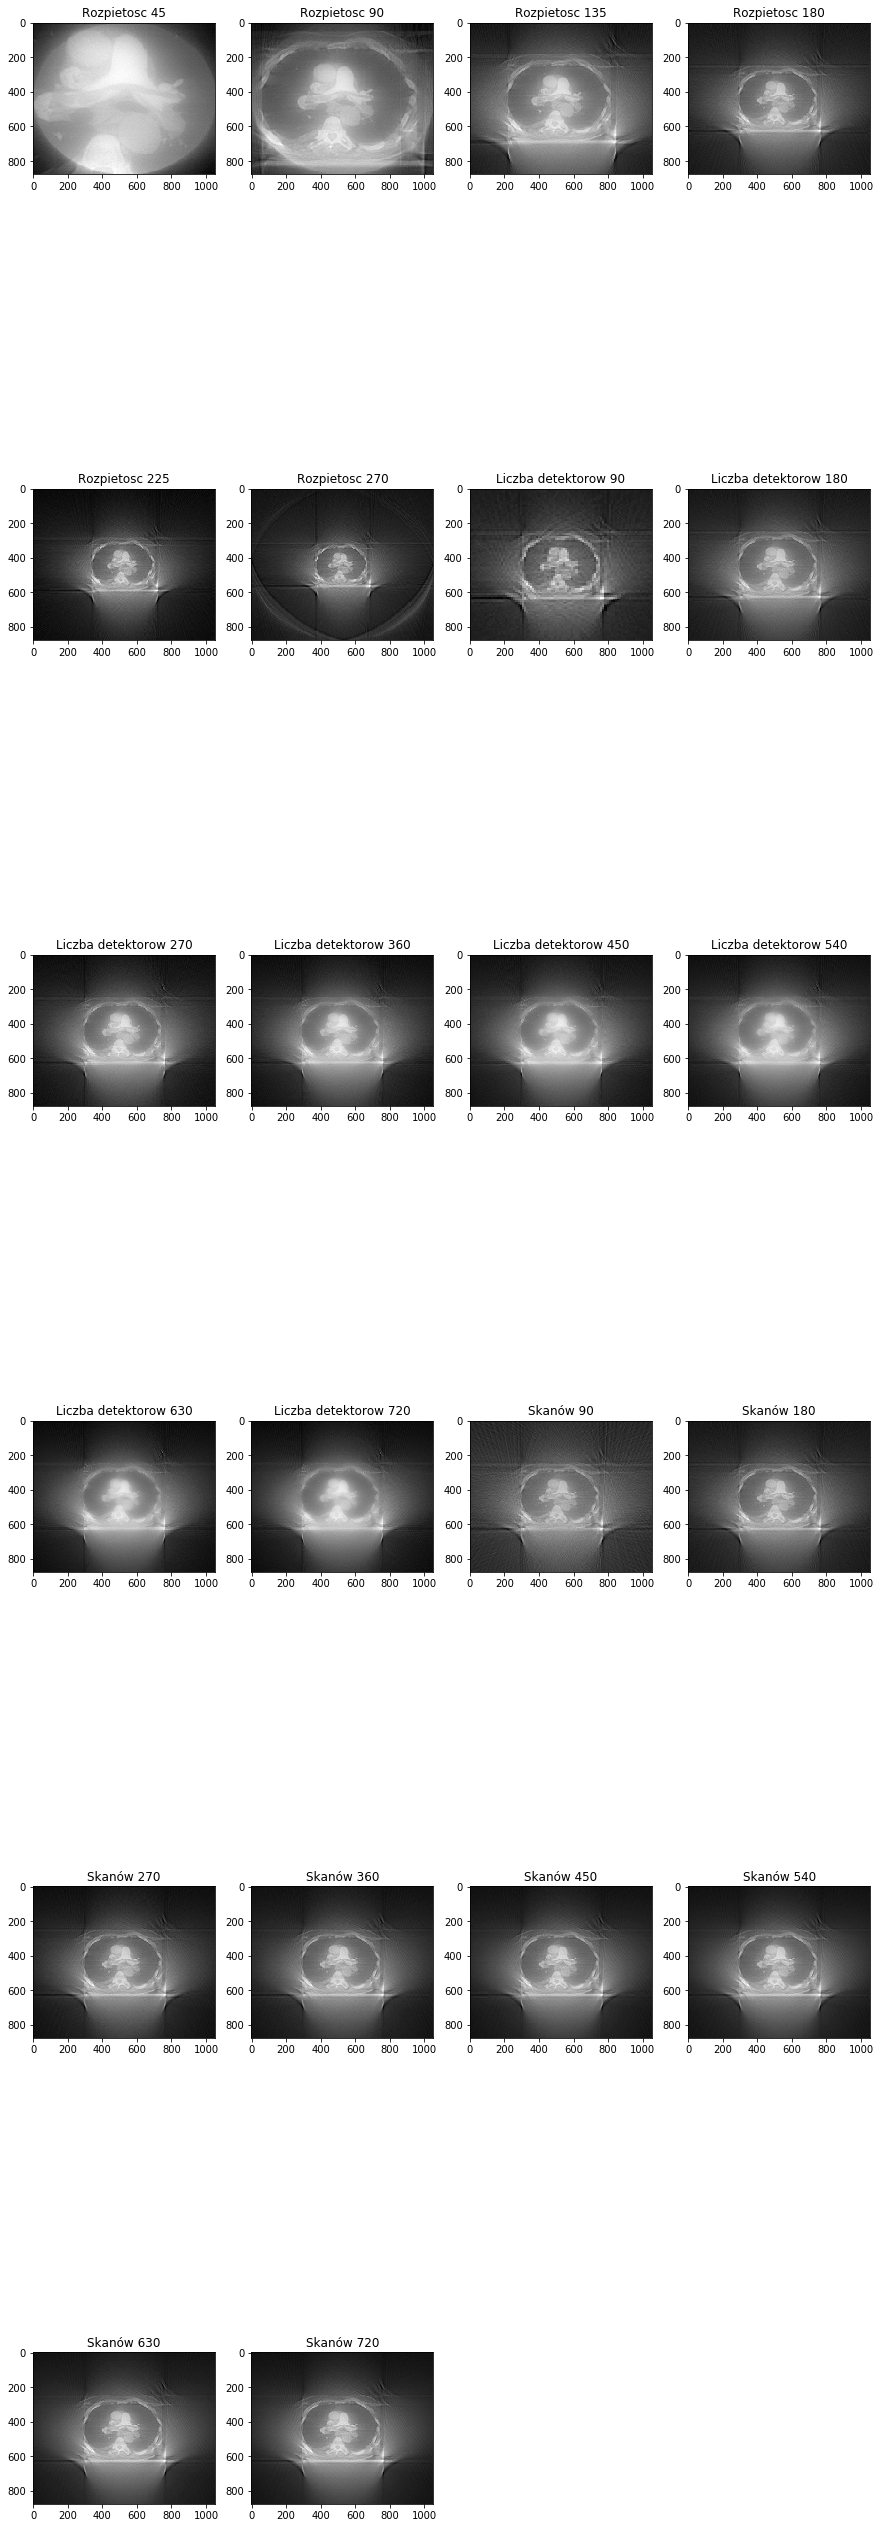

In [300]:
'''i = 1
plt.figure(figsize=(15,50))
for re in rekonstrukcjeR:
    sub = plt.subplot(6,4,i)
    sub.set_title("Rozpietosc "+str(i*45))
    sub.imshow(re, cmap="gray")
    i+=1
for re in rekonstrukcjeL:
    sub = plt.subplot(6,4,i)
    sub.set_title("Liczba detektorow "+str((i-6)*90))
    sub.imshow(re, cmap="gray")
    i+=1
for re in rekonstrukcjeA:
    sub = plt.subplot(6,4,i)
    sub.set_title("Skanów " +str((i-14)*90))
    sub.imshow(re, cmap="gray")
    i+=1
    '''

In [221]:
#ANALIZA
'''dx = 1.0
dAlfa = dx*math.pi/180
rozpietosc = math.pi
liczbaDetektorow = 180
zdjecie2 = misc.imread('SADDLE_PE.JPG', flatten=True).astype('float64')
rekonstrukcja2, projekcje = tomografia(zdjecie2, dAlfa, rozpietosc, liczbaDetektorow, dx)

bladI = []
MSE = 0.0
for l in range(len(projekcje)):
    iteracja = sum(projekcje[:l+1])
    iteracja = iteracja//(l+1)
    iteracja = skalujObraz(iteracja, zdjecie2.shape[1], zdjecie2.shape[0])
    for i in range(zdjecie2.shape[0]):
        for j in range(zdjecie2.shape[1]):
            MSE += (iteracja[i][j] - zdjecie2[i][j])**2    
    MSE = MSE/(zdjecie2.shape[0]*zdjecie2.shape[1])
    print(MSE)
    bladI.append(MSE)'''

"dx = 1.0\ndAlfa = dx*math.pi/180\nrozpietosc = math.pi\nliczbaDetektorow = 180\nzdjecie2 = misc.imread('SADDLE_PE.JPG', flatten=True).astype('float64')\nrekonstrukcja2, projekcje = tomografia(zdjecie2, dAlfa, rozpietosc, liczbaDetektorow, dx)\n\nbladI = []\nMSE = 0.0\nfor l in range(len(projekcje)):\n    iteracja = sum(projekcje[:l+1])\n    iteracja = iteracja//(l+1)\n    iteracja = skalujObraz(iteracja, zdjecie2.shape[1], zdjecie2.shape[0])\n    for i in range(zdjecie2.shape[0]):\n        for j in range(zdjecie2.shape[1]):\n            MSE += (iteracja[i][j] - zdjecie2[i][j])**2    \n    MSE = MSE/(zdjecie2.shape[0]*zdjecie2.shape[1])\n    print(MSE)\n    bladI.append(MSE)"

<function matplotlib.pyplot.show(*args, **kw)>

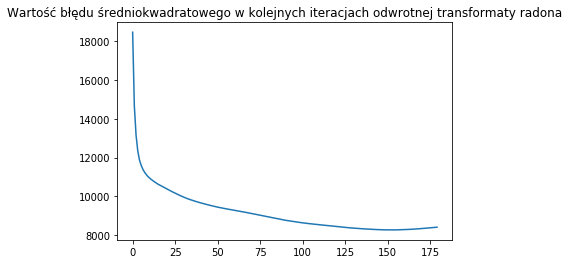

In [214]:
plt.plot(bladI)
plt.title("Wartość błędu średniokwadratowego w kolejnych iteracjach odwrotnej transformaty radona")
plt.show

<font size="5">**Eksperyment z filtrem i dwoma obrazami**</font>

In [304]:

'''dx = 0.5
dAlfa = dx*math.pi/180
rozpietosc = math.pi*3/2
liczbaDetektorow = 360
filtry = [True, False]
zdjecia = ['SADDLE_PE.JPG', 'Shepp_logan.jpg']
bladF = []
rekonstrukcje5 = []
for nazwa in zdjecia:
    for fil in filtry:
        zdjecie3 = misc.imread(nazwa, flatten=True).astype('float64')
        rekonstrukcja2 = tomografia(zdjecie3, dAlfa, rozpietosc, liczbaDetektorow, dx, fil)
        rekonstrukcja2 = skalujObraz(rekonstrukcja2, zdjecie3.shape[1], zdjecie3.shape[0])
        rekonstrukcje5.append(rekonstrukcja2)
        MSE = 0.0
        for i in range(zdjecie3.shape[0]):
            for j in range(zdjecie3.shape[1]):
                MSE += (rekonstrukcja2[i][j] - zdjecie3[i][j])**2

        MSE = MSE/(zdjecie3.shape[0]*zdjecie3.shape[1])
        RMSE = MSE**0.5
        print(RMSE)
        bladF.append(RMSE)'''

C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


94.40106511731379
94.38157550948354
57.96337574520786
57.975923819211715


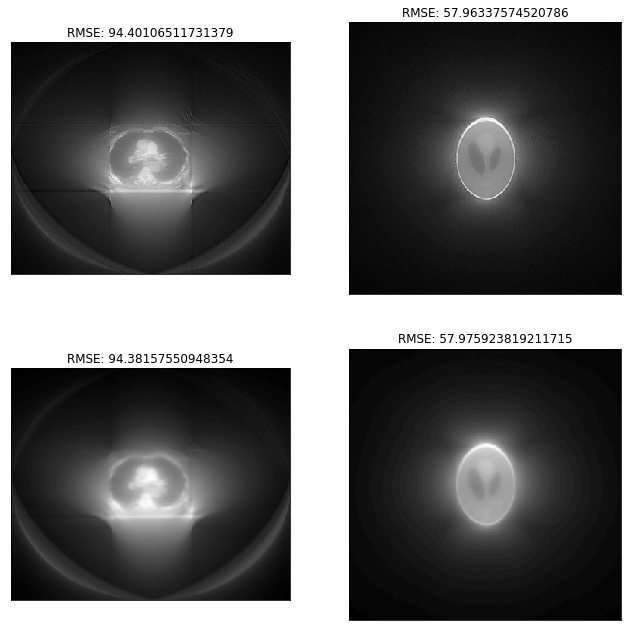

In [315]:
plt.figure(figsize=(11,11))
sub1 = plt.subplot(221)
sub2 = plt.subplot(222)
sub3 = plt.subplot(223)
sub4 = plt.subplot(224)
sub1.set_title("RMSE: " + str(bladF[0]))
sub1.set_xticks([],[])
sub1.set_yticks([],[])
sub1.imshow(rekonstrukcje5[0], cmap='gray')
sub2.set_title("RMSE: " + str(bladF[2]))
sub2.set_xticks([],[])
sub2.set_yticks([],[])
sub2.imshow(rekonstrukcje5[2], cmap='gray')
sub3.set_title("RMSE: " + str(bladF[1]))
sub3.set_xticks([],[])
sub3.set_yticks([],[])
sub3.imshow(rekonstrukcje5[1], cmap='gray')
sub4.set_title("RMSE: " + str(bladF[3]))
sub4.set_xticks([],[])
sub4.set_yticks([],[])
sub4.imshow(rekonstrukcje5[3], cmap='gray')